# Creating linearly variable color maps

The custom colormaps created here can vary from white-red to white-purple (color spectrum). 765 variations are currently possible, but it could be more or less by addind some small changes, if necessary.

Using the _**`create_custom_colormap function`**_, we get as an output _**`cmap`**_ and _**`color_map`**_. cmap is the matrix containing the rgb values. color_map is the object that can be used in matplotlib (imshow) as an actual colormap, on any image.

Let us define some functions.

In [1]:
import matplotlib.pyplot as plt
import numpy as np      
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.cm as cm

def create_image():
    '''
    Create some random image on which we will apply the colormap. Any other image could replace this one.
    '''

    dx, dy = 0.015, 0.05
    x = np.arange(-4.0, 4.0, dx)
    y = np.arange(-4.0, 4.0, dy)
    X, Y = np.meshgrid(x, y)

    def z_fun(x, y):
        return (1 - x / 2 + x**5 + y**6) * np.exp(-(x**2 + y**2))

    Z2 = z_fun(X, Y)
    return(Z2)


def create_cmap(**kwargs):
    '''
    Create a color matrix and a color map using 3 lists of r (red), g (green) and b (blue) values.

    Parameters:
    - r (list of floats): red value, between 0 and 1
    - g (list of floats): green value, between 0 and 1
    - b (list of floats): blue value, between 0 and 1
    - mix_cmaps (boolean): for higher values un image enhancement
    - apply_segmentation (boolean): add a delineation between two ranges of values in the image (ex. cutoff: median)

    Returns:
    - color_matrix (numpy 2D array): contains all the rgb values for a given colormap
    - color_map (matplotlib object): the color_matrix transformed into an object that matplotlib can use on figures
    '''

    ### Init rgba matrix
    color_matrix = np.empty([256, 4])
    color_matrix.fill(0)

    ### Fill our empty matrix with our r,g,b values
    color_matrix[:, 0] = kwargs["r"]
    color_matrix[:, 1] = kwargs["g"]
    color_matrix[:, 2] = kwargs["b"]
    color_matrix[:, 3] = np.repeat(1, len(kwargs["b"]))  # alpha channel

    if kwargs["mix_cmaps"]:
        ### Mix 2 color maps: < our custom cmap > and < matplotlib RdGy cmap >
        RdGy_cmap = cm.get_cmap('RdGy', 256)
        RdGy_matrix = RdGy_cmap(np.linspace(0, 1, 256))

        data_selection1 = np.arange(0, 128, 1)
        data_selection2 = np.arange(0, 256, 2)
        cmap1_short = RdGy_matrix[data_selection1]
        cmap2_short = color_matrix[data_selection2]
        cmap_full = np.concatenate([cmap1_short, cmap2_short])
        
    if kwargs["mix_cmaps"] and kwargs["apply_segmentation"]:
        ### Add some transparency, except for the firt color of the color map (row=0)
        cmap_full[:, 3] = 0.9
        cmap_full[0, 3] = 1
        
        ### Add a black delineation
        white = (1, 1, 1, 1)
        black = (0, 0, 0, 1)
        cmap_full[121:130,:] = black


        ### Convert our r,g,b matrix to a matplotlib colormap object
        #color_map = ListedColormap(color_matrix)

    if kwargs["mix_cmaps"]:        
        color_map = ListedColormap(cmap_full)
    else: 
        color_map = ListedColormap(color_matrix)
        
    
    return(color_matrix, color_map) 


def standardize_timeseries_between(timeseries, borne_inf = 0, borne_sup = 1):
    '''
    For lisibility reasons, I defined r,g,b values between 0 and 255. But the matplotlib ListedColormap function expects values between 0 and 1.

    Parameters:
    timeseries (list of floats): can be one color vector in our case (either r, g o r b)
    borne_inf (int): The minimum value in our timeseries will be replaced by this value
    borne_sup (int): The maximum value in our timeseries will be replaced by this value
    '''

    timeseries_standardized = []

    for i in range(len(timeseries)):
        a = (borne_sup - borne_inf) / (max(timeseries) - min(timeseries))
        b = borne_inf - a * min(timeseries)

        timeseries_standardized.append(a * timeseries[i] + b)

    timeseries_standardized = np.array(timeseries_standardized)
    return(timeseries_standardized)

def create_custom_colormap(weight, mix_cmaps=True, apply_segmentation=True):
    '''
    This function is at the heart of the process. It takes only one < weight > parameter, that you can chose. 
    - For weight between 0 and 255, the colormaps that are created will vary between white-red (min-max) to white-yellow (min-max).
    - For weight between 256 and 510, the colormaps that are created will vary between white-green (min-max) to white-cyan (min-max).
    - For weight between 511 and 765, the colormaps that are created will vary between white-blue (min-max) to white-purple (min-max).
    '''    
    if weight <= 255:
        ### 0>w<255
        r = np.repeat(1, 256)

        g = np.arange(0, 256, 1)
        g = standardize_timeseries_between(g, weight/256, 1)
        g = g[::-1]

        b = np.arange(0, 256, 1)
        b = standardize_timeseries_between(b, 1/256, 1)
        b = b[::-1]

    if weight > 255 and weight <= 255*2:
        weight = weight - 255

        ### 255>w<510
        g = np.repeat(1, 256)

        r = np.arange(0, 256, 1)
        r = standardize_timeseries_between(r, 1/256, 1)
        r = r[::-1]
        
        b = np.arange(0, 256, 1)
        b = standardize_timeseries_between(b, weight/256, 1)
        b = b[::-1]

    if weight > 255*2 and weight <= 255*3:
        weight = weight - 255*2

        ### 510>w<765
        b = np.repeat(1, 256)

        r = np.arange(0, 256, 1)
        r = standardize_timeseries_between(r, weight/256, 1)
        r = r[::-1]
        
        g = np.arange(0, 256, 1)
        g = standardize_timeseries_between(g, 1/256, 1)
        g = g[::-1]


    cmap, color_map = create_cmap(r=r,g=g,b=b,mix_cmaps=mix_cmaps,apply_segmentation=apply_segmentation)

    return(cmap, color_map)

# Example 1

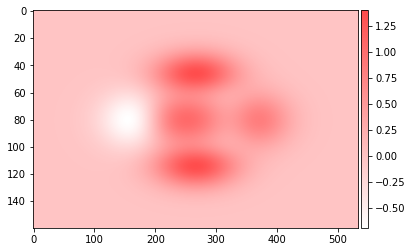

In [2]:
### Cmap full red
r = np.repeat(1,256)

g = np.arange(0,256,1)
g = standardize_timeseries_between(g,1/256,1)
g = g[::-1]

b = np.arange(0,256,1)
b = standardize_timeseries_between(b,1/256,1)
b = b[::-1]   
cmap, color_map = create_cmap(r=r,g=g,b=b,mix_cmaps=False,apply_segmentation=False)

#- Create image
Z2 = create_image()
f, ax = plt.subplots()
img = ax.imshow(Z2, cmap =color_map, alpha = 0.7, 
           interpolation ='bilinear', aspect = "auto")

#- Create colorbar
aspect = 20
pad_fraction = 0.5
divider = make_axes_locatable(ax)
height = axes_size.AxesX(ax, aspect=2/100)
pad = axes_size.Fraction(0.5, height)
cax = divider.append_axes("right", size=height, pad=pad)
cax.tick_params(axis='both', which='major')
plt.colorbar(img, cax=cax, orientation="vertical")

# Example 2

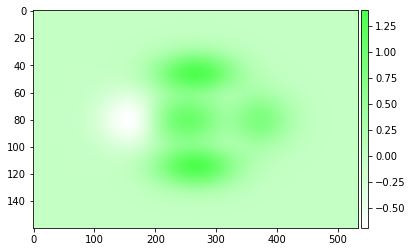

In [3]:
### Cmap full green 
g = np.repeat(1,256)

r = np.arange(0,256,1)
r = standardize_timeseries_between(r,1/256,1)
r = r[::-1]

b = np.arange(0,256,1)
b = standardize_timeseries_between(b,1/256,1)
b = b[::-1]   
cmap, color_map = create_cmap(r=r,g=g,b=b,mix_cmaps=False,apply_segmentation=False)

#- Create image
Z2 = create_image()
f, ax = plt.subplots()
img = ax.imshow(Z2, cmap =color_map, alpha = 0.7, 
           interpolation ='bilinear', aspect = "auto")

#- Create colorbar
aspect = 20
pad_fraction = 0.5
divider = make_axes_locatable(ax)
height = axes_size.AxesX(ax, aspect=2/100)
pad = axes_size.Fraction(0.5, height)
cax = divider.append_axes("right", size=height, pad=pad)
cax.tick_params(axis='both', which='major')
plt.colorbar(img, cax=cax, orientation="vertical")

# Example 3

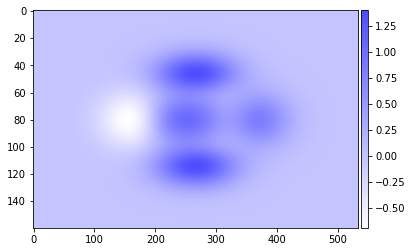

In [4]:
### Cmap full blue 
b = np.repeat(1,256)

g = np.arange(0,256,1)
g = standardize_timeseries_between(g,1/256,1)
g = g[::-1]

r = np.arange(0,256,1)
r = standardize_timeseries_between(r,1/256,1)
r = r[::-1]   
cmap, color_map = create_cmap(r=r,g=g,b=b,mix_cmaps=False,apply_segmentation=False)

#- Create image
Z2 = create_image()
f, ax = plt.subplots()
img = ax.imshow(Z2, cmap =color_map, alpha = 0.7, 
           interpolation ='bilinear', aspect = "auto")

#- Create colorbar
aspect = 20
pad_fraction = 0.5
divider = make_axes_locatable(ax)
height = axes_size.AxesX(ax, aspect=2/100)
pad = axes_size.Fraction(0.5, height)
cax = divider.append_axes("right", size=height, pad=pad)
cax.tick_params(axis='both', which='major')
plt.colorbar(img, cax=cax, orientation="vertical")

# Quick view of all the available color maps

[]

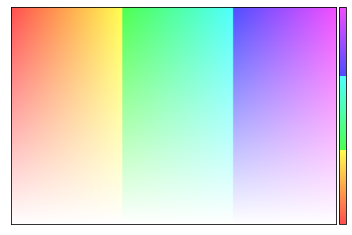

In [5]:
all_colormatrix = []
all_colormax = []

for i in range(750):
    cmap, color_map = create_custom_colormap(i)
    all_colormatrix.append(cmap)
    for j in cmap[254:-1, :]:
        all_colormax.append(j)

all_colormatrix = np.array(all_colormatrix)
all_colormax = np.array(all_colormax)
all_colormaps = ListedColormap(all_colormax)

#- Create image
Z2 = create_image()
f, ax = plt.subplots()
img = ax.imshow(np.rot90(all_colormatrix,1), cmap =all_colormaps, alpha = 0.7, 
           interpolation ='bilinear', aspect = "auto")
ax.set_yticks([])
ax.set_xticks([])

#- Create colorbar
aspect = 20
pad_fraction = 0.5
divider = make_axes_locatable(ax)
height = axes_size.AxesX(ax, aspect=2/100)
pad = axes_size.Fraction(0.5, height)
cax = divider.append_axes("right", size=height, pad=pad)
cax.tick_params(axis='both', which='major')
plt.colorbar(img, cax=cax, orientation="vertical")
cax.set_yticks([])
cax.set_xticks([]) 

# Apply linear variation of colormaps regarding a weight (w) value

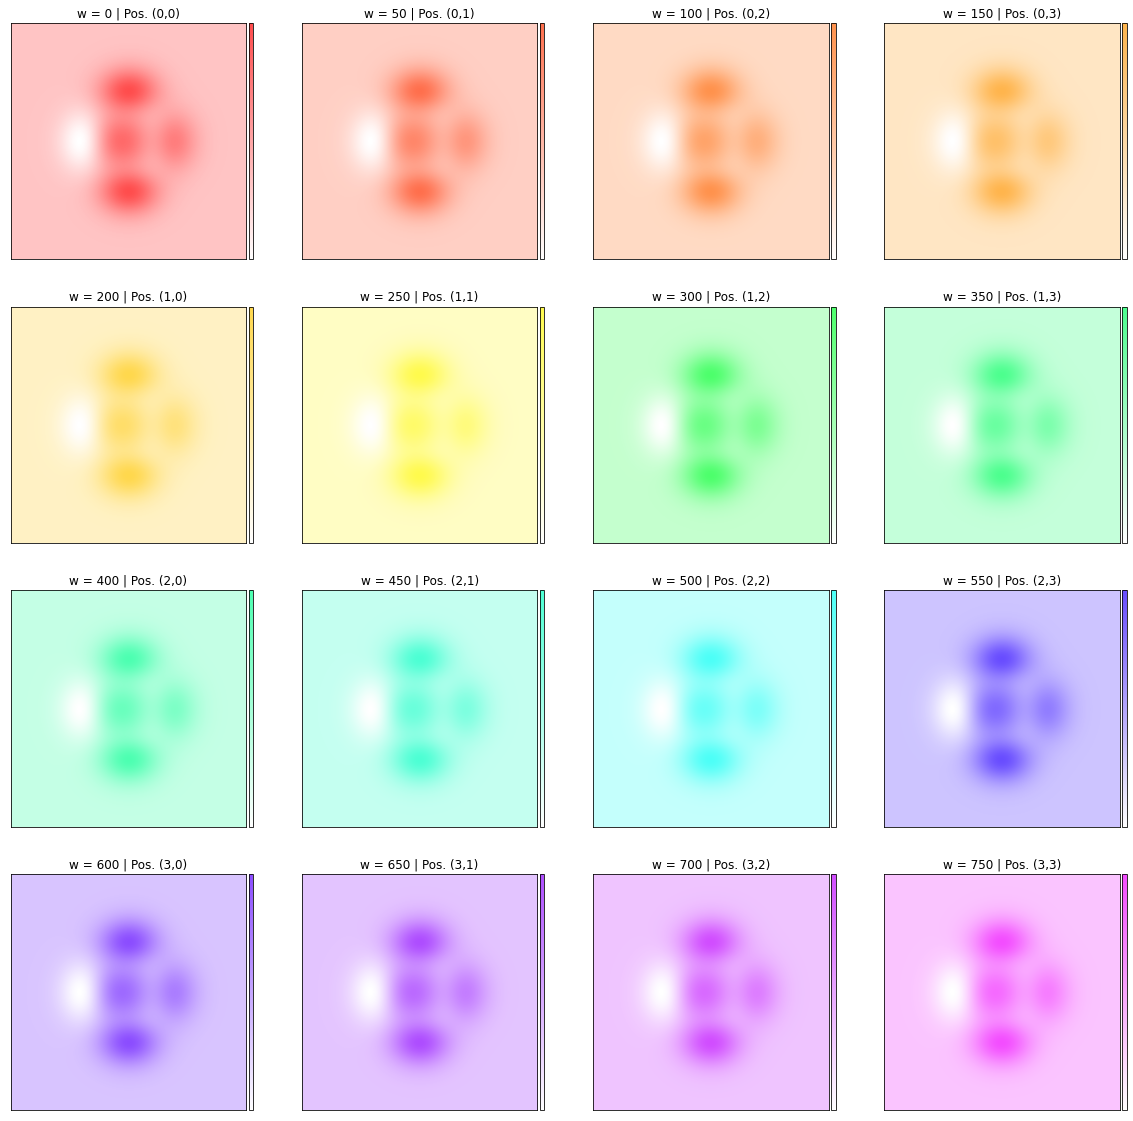

In [7]:
### Let us create some image (any other could be used).
Z2 = create_image()

### Now create a color map, using the w value you want 0 = white-red, 765 = white-purple.
f, ax = plt.subplots(4,4, figsize= (20,20))

col = 0
for i, w in enumerate(np.arange(0,800,50)):
    row = int(i/4)
        
    #- Create image
    cmap, color_map = create_custom_colormap(weight=w,mix_cmaps=False,apply_segmentation=False)
    img = ax[row,col].imshow(Z2, cmap =color_map, alpha=0.7, interpolation ='bilinear',aspect = "auto")
    ax[row,col].set_title("w = {} | Pos. ({},{})".format(w,row,col))    
    ax[row,col].set_yticks([])
    ax[row,col].set_xticks([])
    
    #- Create colorbar
    aspect = 20
    pad_fraction = 0.5
    divider = make_axes_locatable(ax[row,col])
    height = axes_size.AxesX(ax[row,col], aspect=2/100)
    pad = axes_size.Fraction(0.5, height)
    cax = divider.append_axes("right", size=height, pad=pad)
    cax.tick_params(axis='both', which='major')
    plt.colorbar(img, cax=cax, orientation="vertical")    
    cax.set_yticks([])
    cax.set_xticks([]) 

    col +=1
    if col == 4:
        col = 0    
    

# Combine two colormaps

Redefine the _**`create_cmap`**_ function to mix the custom colormaps with existing colormaps.

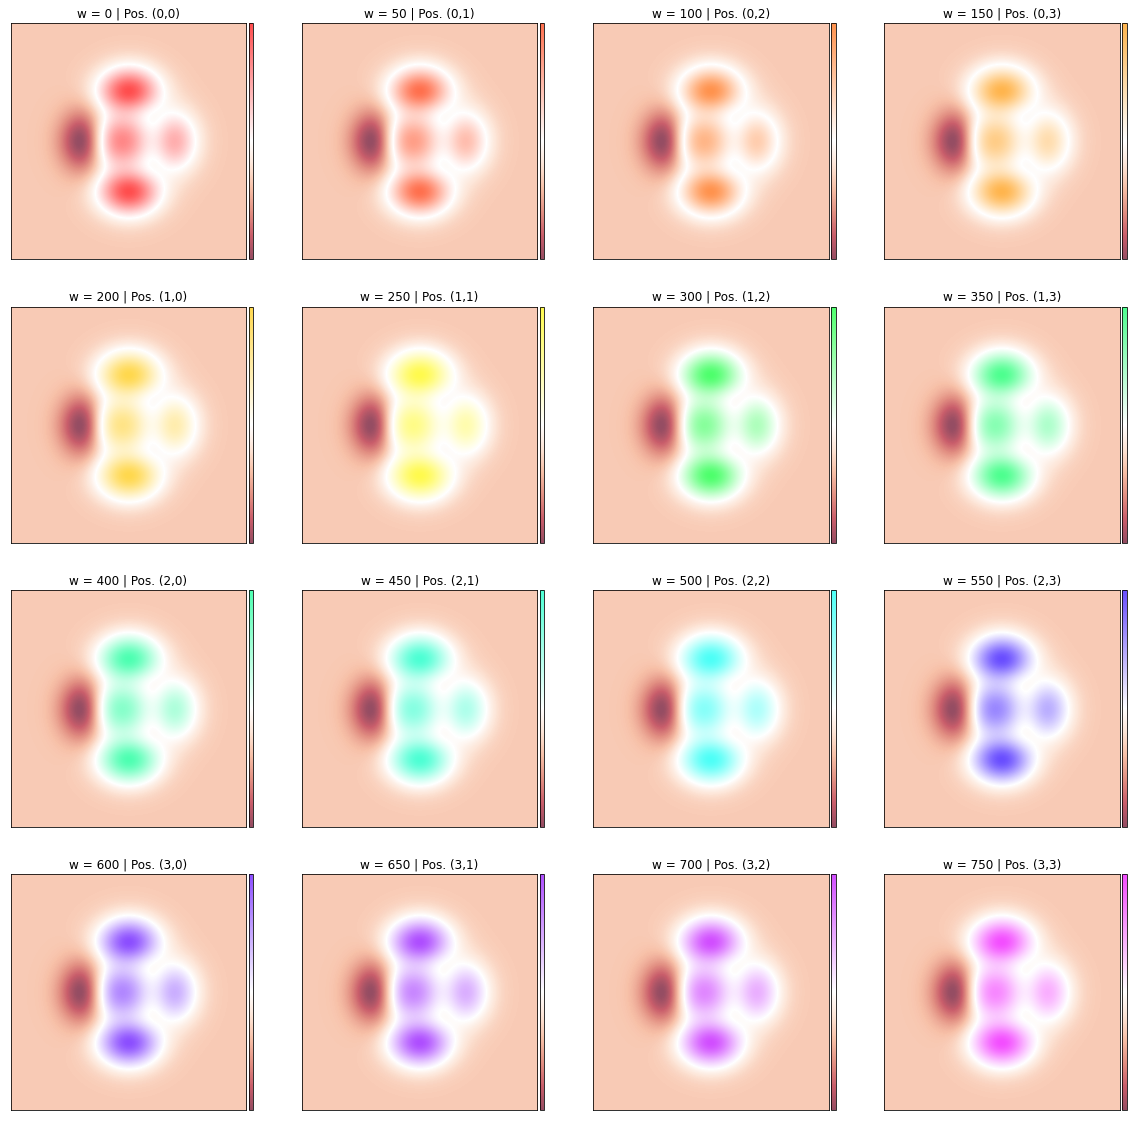

In [9]:
### Let us create some image (any other could be used).
Z2 = create_image()

### Now create a color map, using the w value you want 0 = white-red, 765 = white-purple.
f, ax = plt.subplots(4,4, figsize= (20,20))

col = 0
for i, w in enumerate(np.arange(0,800,50)):
    row = int(i/4)   

    #- Create image
    cmap, color_map = create_custom_colormap(weight=w,mix_cmaps=True,apply_segmentation=False)
    img = ax[row,col].imshow(Z2, cmap =color_map, alpha=0.7, interpolation ='bilinear',aspect = "auto")
    ax[row,col].set_title("w = {} | Pos. ({},{})".format(w,row,col))    
    ax[row,col].set_yticks([])
    ax[row,col].set_xticks([]) 
    
    #- Create colorbar
    aspect = 20
    pad_fraction = 0.5
    divider = make_axes_locatable(ax[row,col])
    height = axes_size.AxesX(ax[row,col], aspect=2/100)
    pad = axes_size.Fraction(0.5, height)
    cax = divider.append_axes("right", size=height, pad=pad)
    cax.tick_params(axis='both', which='major')
    plt.colorbar(img, cax=cax, orientation="vertical")    
    cax.set_yticks([])
    cax.set_xticks([])   
    
    col +=1
    if col == 4:
        col = 0        
    

# Add a delineation/segmentation on the image

Here we fix all the pixels for which the value == 1 to black. So the "inactive" parts of the image are separated from the "active" parts.

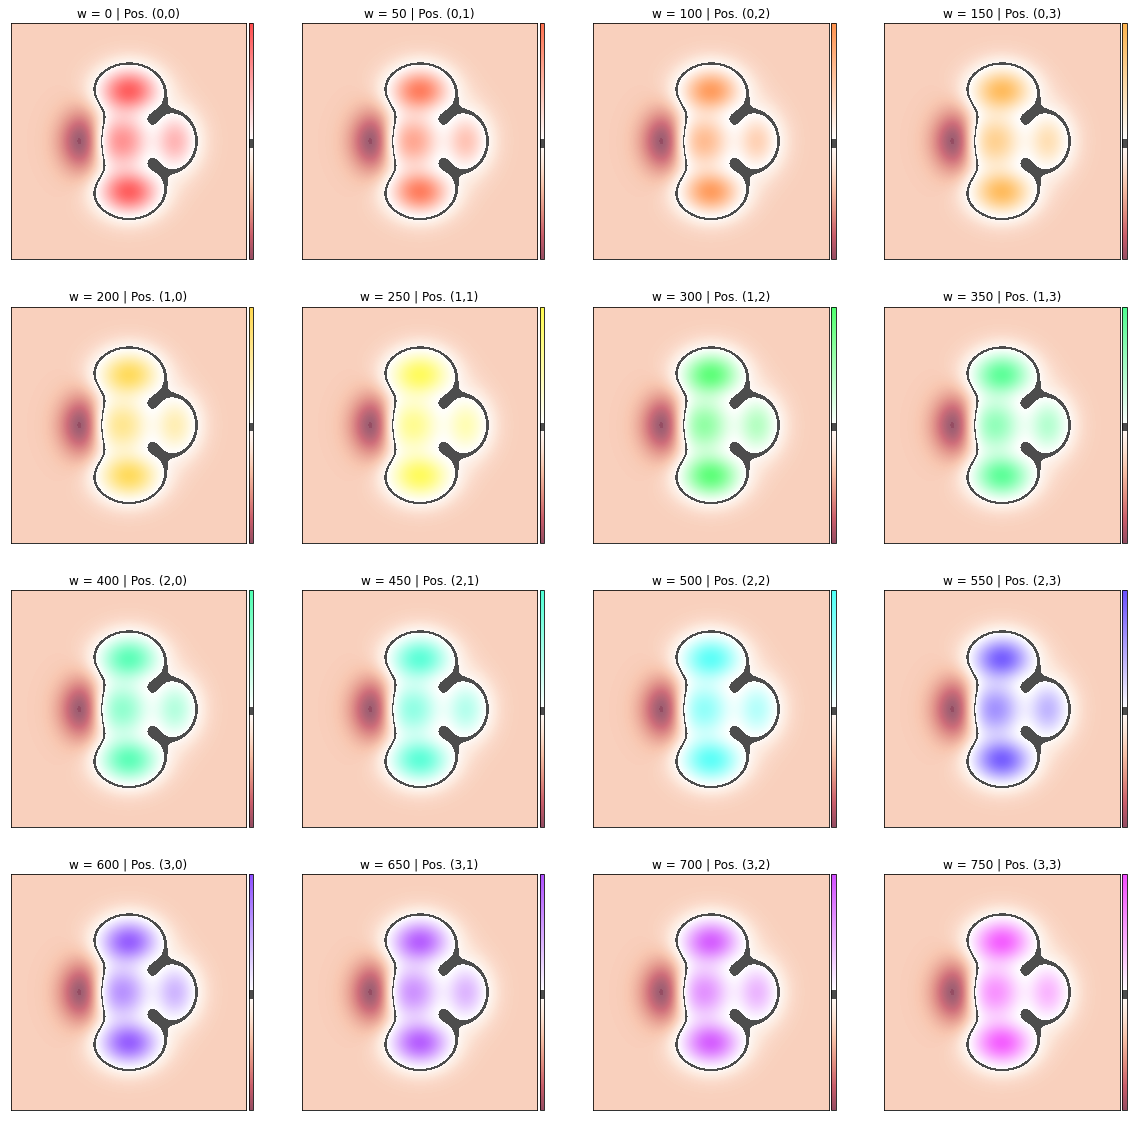

In [10]:
### Let us create some image (any other could be used).
Z2 = create_image()

### Now create a color map, using the w value you want 0 = white-red, 765 = white-purple.
f, ax = plt.subplots(4,4, figsize= (20,20))

col = 0
for i, w in enumerate(np.arange(0,800,50)):
    row = int(i/4)   

    #- Create image
    cmap, color_map = create_custom_colormap(weight=w,mix_cmaps=True,apply_segmentation=True)
    img = ax[row,col].imshow(Z2, cmap =color_map, alpha=0.7, interpolation ='bilinear',aspect = "auto")
    ax[row,col].set_title("w = {} | Pos. ({},{})".format(w,row,col))    
    ax[row,col].set_yticks([])
    ax[row,col].set_xticks([]) 
    
    #- Create colorbar
    aspect = 20
    pad_fraction = 0.5
    divider = make_axes_locatable(ax[row,col])
    height = axes_size.AxesX(ax[row,col], aspect=2/100)
    pad = axes_size.Fraction(0.5, height)
    cax = divider.append_axes("right", size=height, pad=pad)
    cax.tick_params(axis='both', which='major')
    plt.colorbar(img, cax=cax, orientation="vertical")    
    cax.set_yticks([])
    cax.set_xticks([])   
    
    col +=1
    if col == 4:
        col = 0        
    